# Comparing Clustering Algorithms

These examples are taken shamelessly from sklearn. For more info, see:
http://scikit-learn.org/stable/modules/clustering.html

In [19]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

%matplotlib inline

## Comparing different clustering algorithms on toy datasets

This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.

### Generate toy data sets

In [20]:
np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

### Set up clustering parameters

In [21]:
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

### Run algorithms

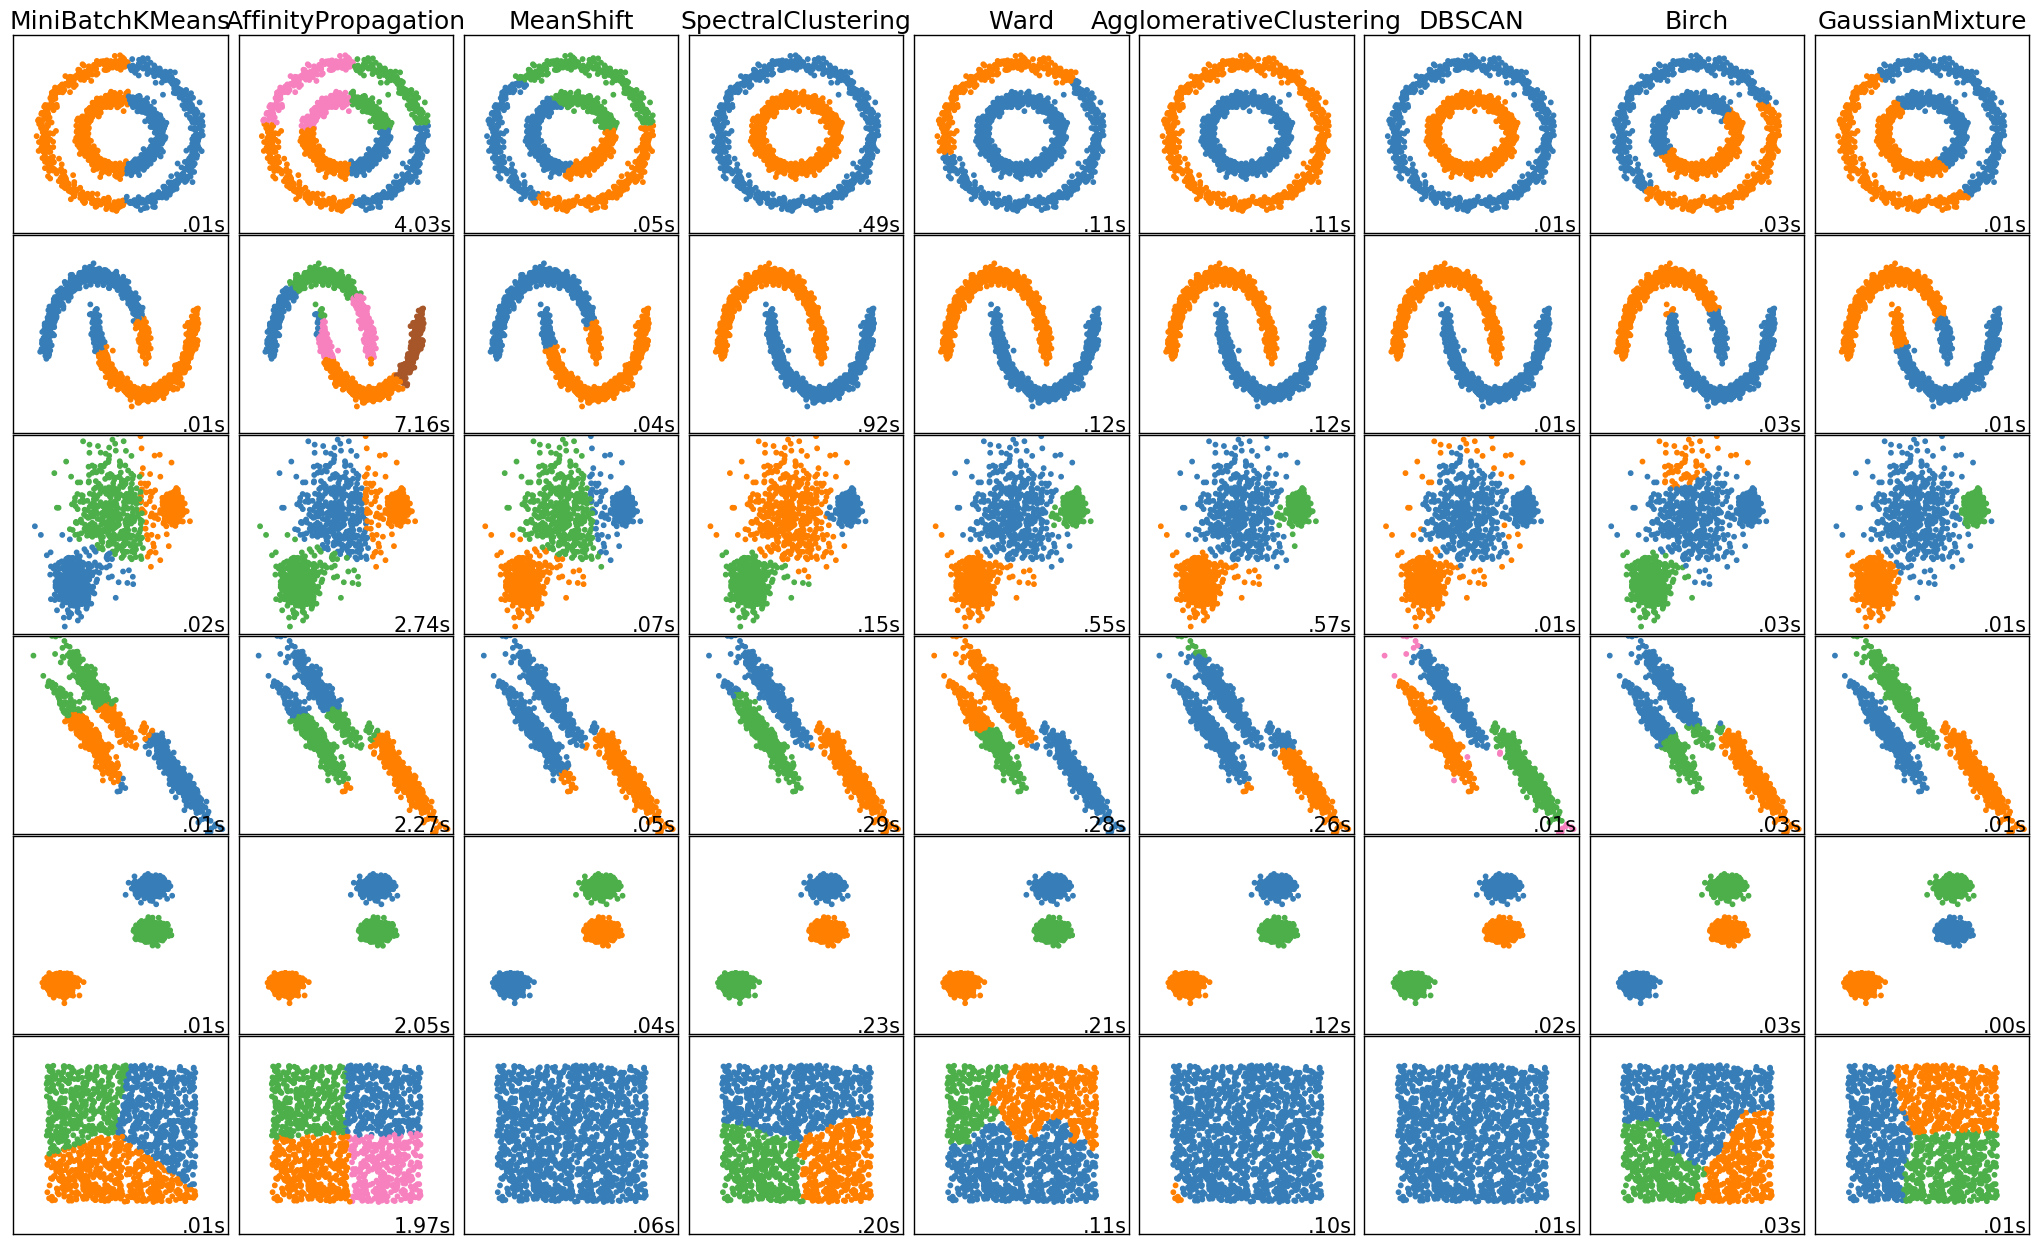

In [22]:
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1



for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1


plt.show()

## Question to the group:  Which 3 of these algorithms look overall the best?


How do you separate the clusters?  There are usually two main possibilities of a hyperparameter:
1.  Properties of the data themselves:  density of points (minimum number of points and the area), distance between points, etc.
2.  The number of clusters

## Hierarchichal Clustering

This type of clustering groups points by ranking them from below (agglomerative) or above (divisive).  It merges close points into clusters based on the distance between them.

We will only briefly discuss the former.


## 1. Agglomerative Clustering

- You start with K(clusters) = N(points)
- You calculate the distances between all of the pairs of points
- Connect the nearest pairs of points iteratively for N iterations until you have a single cluster (build the dendrogram below)
- Define a number of clusters (stop at K clusters) or a distance threshold that separates the clusters
- Merge all clusters below that threshold

Complexity: $O(n^2 d + n^3)$ => very slow; more expensive than k-means or DBSCAN

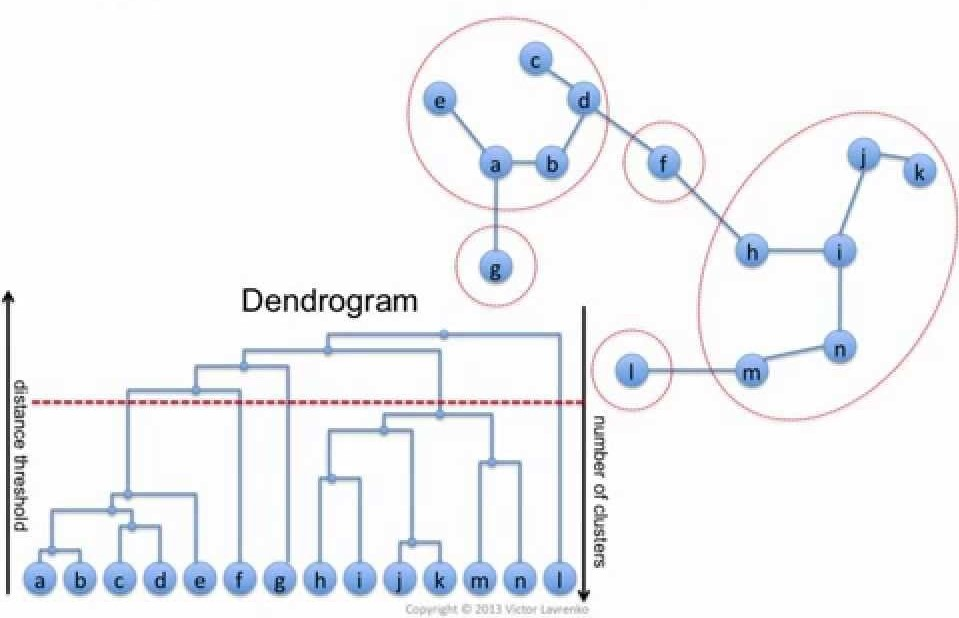

In [24]:
from IPython.display import Image
Image(filename='agglomeratice_pic1.PNG',  width=500, height=100)

### *How do you calculate the distance?*


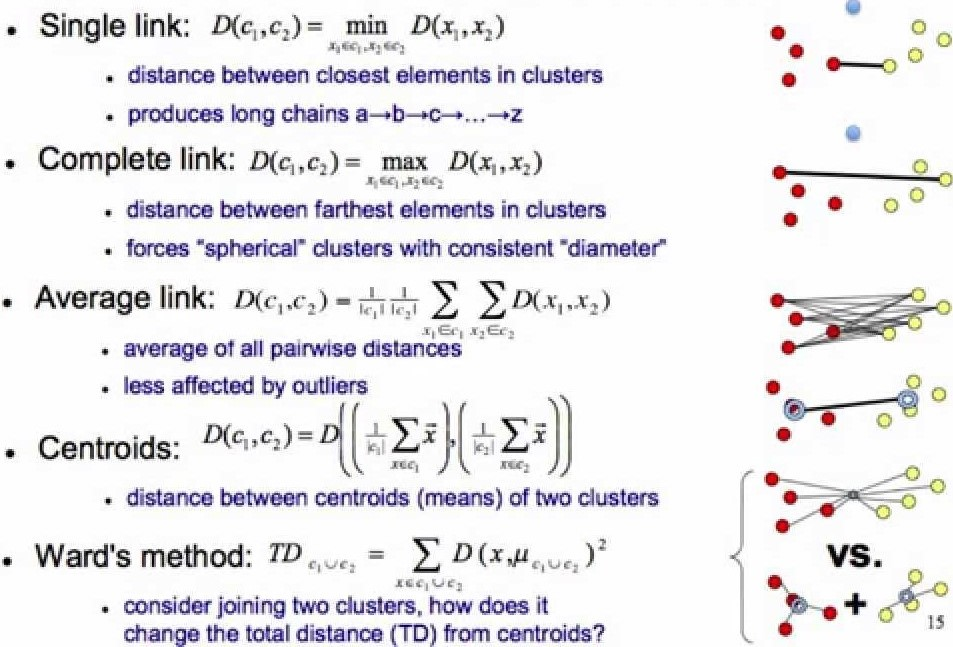

In [25]:
from IPython.display import Image
Image(filename='cluster_distances.PNG',  width=750, height=140)

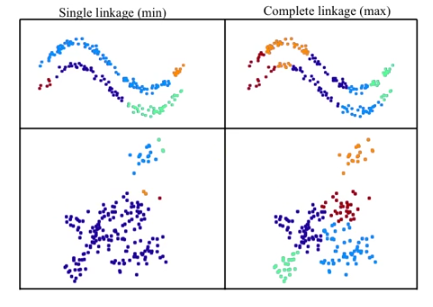

In [26]:
from IPython.display import Image
Image(filename='cluster_distances_example.PNG',  width=500, height=100)

## 2. DBSCAN
(Density Based Spatial Clustering of Applications with Noise)

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density, and thus clusters found by DBSCAN can be any shape, as opposed to other algorithms (k-means for example) which assumes that clusters are convex shaped.

2 parameters: Eps (neighborhood size)and MinPts (minimum points) minimum points for a neighborhood to be considered dense.

With 1 scan we label the points as: core, border, noise. How?
-  A point p is a core point if at least minPts points are within the area defined by Eps
-  A border point is a non-core point that has at least 1 core point in its neighborhood
-  A noise point is neither a core nor a border point. There represent outliers in the data set.

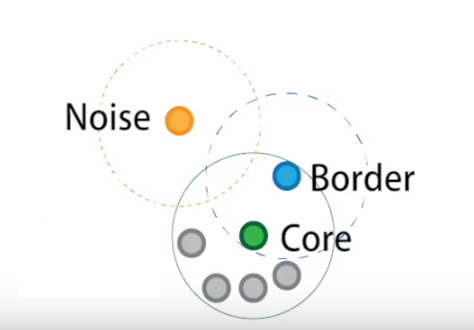

In [10]:
from IPython.display import Image
Image(filename='dbscan_pic1.PNG')

### Procedure:

1. Algorithm picks 1 unassigned core point (p). 
2. Let p be the current point being explored
3. Add all points (q) of p’s neighborhood to the same cluster
4. Some of these q points are also core points so: recursively apply this search on each unexplored core point of this neighborhood.
5. DBSCAN repeats the search until all core points have been assigned to a cluster.

In [30]:
from IPython.display import HTML
HTML('<img src="clustering-dbscan-smiley.gif">')

### Pros:
-  Any number of clusters
-  Clusters of varying size and shape
-  Find and ignore outliers
-  Very fast

### Cons:
-  Sensitive to parameter choice: If Eps is too small, then small clusters will be considered noise. If Eps is too large, then dense clusters will be merged together.

## 3. Gaussian Mixtures

A mixture model is like it sounds: you mix a set of probability distributions together to get the probabilities of each data point corresponding to each distribution. Gaussians are commonly used because of their unique, relatively simple properties, but other distributions could be used as well.

The Gaussian mixture method essentially jointly fits gaussians to the dataset, incorporating their centers and widths, the latter specified by a covariance matrix. The one hyperparameter is the number of gaussians, which the user needs to determine (e.g., cross validation, physical reasons). Because we are using a covariance matrix to specify the widths, the clusters can be characterized as ellipsoids, most generally.

## The Expectation Maximum Algorithm

The core of the method (why it is so fast and works so well) is this algorithm, which takes advantage of the unique properties of a gaussians.  I have tried to boil it down and not get stuck in the mathematical details (see 4.4 of Jeff's statistic book if you want more details).

As usual, the goal is to maximize the log of the likelihood function.  Recall a basic, fundamental idea in calculus: you can find an extremum of a distribution by taking the derivative and setting it equal to 0.  This is exactly what the EM algorithm does.  I have thought of it as analogous to the least squares method of finding the parameters of a line fit to data.

When taking the derivative of the log of the likelihood, you get two terms...

1.  The class probability or weights for the $i$th point and $j$th Gaussian, G with $\alpha_j$ as normalizing constants (comes from Bayes rule):

    $\Large w_{ij} = p(j|x_i) = \frac {\alpha_j G(\mu_j,\sigma_j)} {\sum_{j=1}^M \alpha_j G(\mu_j,\sigma_j)}$

2.  The partial derivative of the parameters of the Gaussians, $\theta_j$.

The total likelihood is

$\Large \frac {\partial \ln {\rm L}} {\partial \theta_j} = - \sum_{i=1}^N w_{ij} \frac {\partial} {\partial \theta_j} [\ln \sigma_j + \frac {(x_i - \mu_j)^2} {2\sigma_j^2}]$

Then by setting the second term to 0 (math...), you happen to get very simple expressions of the local estimators of the normalizations, means, and standard deviations of the Gaussians, which are just the normalized sum of the weights, the weighted average, and the weighted standard deviations for the $i$th point and $j$th Gaussian:

$\large \alpha_j = \frac {1} {N} \sum_{i=1}^N w_{ij}$

$\Large \mu_j = \frac {\sum_{i=1}^N w_{ij} x_i} {\sum_{i=1}^N w_{ij}}$

$\Large \sigma_j^2 = \frac {\sum_{i=1}^N w_{ij} (x_i - \mu_j)^2} {\sum_{i=1}^N w_{ij}}$

There are two steps: the expectation step (calculate $w_{ij}$) and the maximiziation step (calculate $\alpha$, $\mu$, and $\sigma$).  Values for the parameters (starting from random) are updated iteratively until the algorithm converges to a (local) maximum.  It is intuitive to see that such simple mathematical operations would be fast and very straight-forward to compute.

You can incorporate uncertainties in the data points, but only in homoscedastic errors (same for all data points; e.g., a systematic error) in quadrature in order to preserve the simple mathematical form above.  Including independent uncertainties or different distributions are possible but requires a reformulation and the equations don't have the simple solutions above (not Gaussian, numerical integration required).

Pros:

* very fast
* you can calculate robust statistics (under Gaussian assumptions)
    * the centers of widths of the clusters
    * probabilities of points belonging to various gaussians (which cluster is each point more likely to belong to?)
* no bias in the cluster centers or widths (because you are simply maximizing the likelihood)

Cons:

* must specify the number of Gaussians ahead of time, though the algorithm may find a solution with zero amplitude

*Works best with fairly well-behaved, Gaussian-like data...*
* the most general characterization for the clusters are ellipsoids
* limited by the expectation maximum algorithm
    * can get stuck in local minima
    * needs a sufficient number of points to characterize the gaussian ("the algorithm is known to diverge and find solutions with infinite likelihood unless one regularizes the covariances artificially")
    * can have problems with strong outliers and duplicate datapoints

## Pleiades Example

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice

%matplotlib inline
data = np.load('region_11993.npy')

print(data.shape)
print(data.dtype)

(7879,)
[('solution_id', '<i8'), ('source_id', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('pmra', '<f8'), ('pmra_error', '<f8'), ('pmdec', '<f8'), ('pmdec_error', '<f8'), ('parallax', '<f8'), ('parallax_error', '<f8'), ('parallax_pmra_corr', '<f8'), ('parallax_pmdec_corr', '<f8'), ('pmra_pmdec_corr', '<f8'), ('phot_g_mean_mag', '<f8'), ('phot_bp_mean_mag', '<f8'), ('phot_rp_mean_mag', '<f8'), ('duplicated_source', '?')]


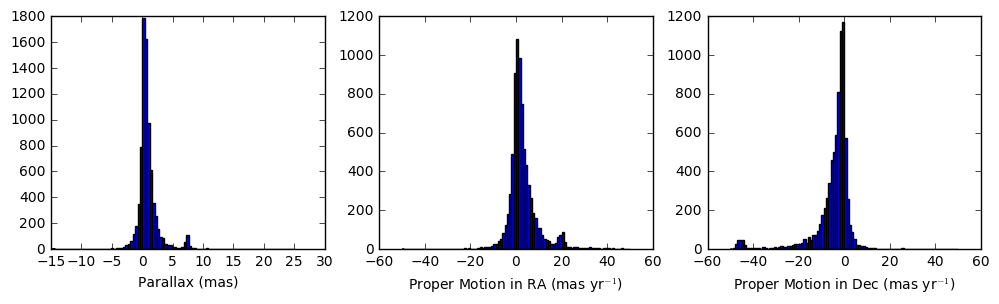

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].hist(data['parallax'], bins=100)
ax[1].hist(data['pmra'], bins=100, range=(-50, 50))
ax[2].hist(data['pmdec'], bins=100, range=(-50, 50))

ax[0].set_xlabel('Parallax (mas)')
ax[1].set_xlabel(r'Proper Motion in RA (mas yr$^{-1}$)')
ax[2].set_xlabel(r'Proper Motion in Dec (mas yr$^{-1}$)')

plt.show()

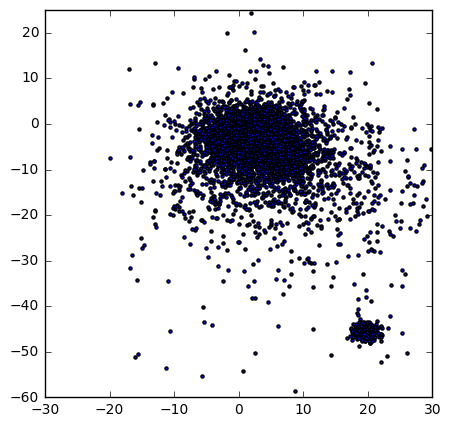

In [64]:
plt.figure(figsize=(5,5))
plt.scatter(data['pmra'], data['pmdec'], marker='.')

plt.xlim(-30, 30)
plt.ylim(-60, 25)

plt.show()

### Create data array

In [34]:
data = data[data['pmra'] > -20.0]
data = data[data['pmra'] < 30.0]
data = data[data['pmdec'] < 25.0]
data = data[data['pmdec'] > -60]

X = np.zeros((len(data), 3))

X[:,0] = data['parallax']
X[:,1] = data['pmra']
X[:,2] = data['pmdec']

### Set up algorithms

In [50]:
#cluster.DBSCAN?
#cluster.AgglomerativeClustering?
#mixture.GaussianMixture?

In [67]:
n_clusters = 4

# connectivity matrix for structured Ward
#connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
# make connectivity symmetric
#connectivity = 0.5 * (connectivity + connectivity.T)


# Fitting parameters
#ward = cluster.AgglomerativeClustering(
#    n_clusters=n_clusters, linkage='ward',
#    connectivity=connectivity)

dbscan = cluster.DBSCAN(eps=5, min_samples=35)

#average_linkage = cluster.AgglomerativeClustering(
#    linkage="complete", affinity="cityblock",
#    n_clusters=n_clusters, connectivity=connectivity)

gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')



clustering_algorithms = (
#    ('Ward', ward),
#    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('GaussianMixture', gmm)
)

### Run algorithms and create plot

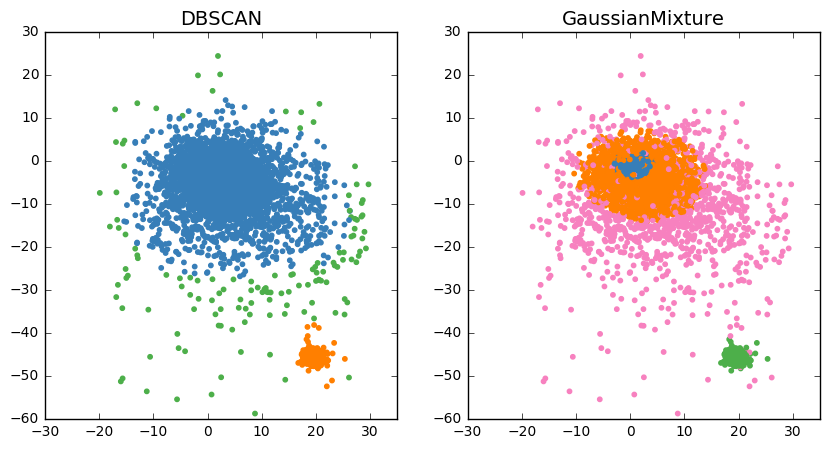

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

for i, (name, algorithm) in enumerate(clustering_algorithms):

    algorithm.fit(X)

    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    ax[i].set_title(name, size=14)

    y_pred[y_pred == -1] = np.max(y_pred) + 1

    
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))

    ax[i].scatter(X[y_pred!=-1, 1], X[y_pred!=-1, 2], s=10, color=colors[y_pred[y_pred!=-1]])

    ax[i].set_xlim(-30, 35)
    ax[i].set_ylim(-60, 30)
    
plt.show()